In [1]:
from utils import * 
from algorithms import *
from agents import *

# parameters
depth = 1
numStates = 28
disclosure = ['step', 'currentBid', 'currentAsk', 'buy', 'sell', 'price', 'sale','currentBidIdx_0', 'currentBidIdx_1', 'currentBidIdx_2', 'currentBidIdx_3','currentAskIdx_0', 'currentAskIdx_1', 'currentAskIdx_2', 'currentAskIdx_3','bids_0', 'bids_1', 'bids_2', 'bids_3', 'asks_0', 'asks_1', 'asks_2', 'asks_3']

# game setup
numRounds, numPeriods, numSteps, numBuyers, numSellers, numTokens, gameTypes, seed = 5000, 1, 16, 4, 4, 4, '1111', None
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]

# algo params
episodeLength = 16
numTrajectories = 10
gamma=0.99
std_init = 0.7
std_decay = 0.995
std_min = 0.05
lr = 0.0003
k = -0.15
p = 0.3

# agents
buyers = [
    Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, verbose =0, numStates = numStates, algo='VPGContinuous',algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr, k, p]),
    Reinforcer(gameData, disclosure, index=1, buyer=1, reinforcer=1, verbose =0, numStates = numStates, algo='VPGContinuous',algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr, k, p]),
    Reinforcer(gameData, disclosure, index=2, buyer=1, reinforcer=1, verbose =0, numStates = numStates, algo='VPGContinuous',algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr, k, p]),
    Reinforcer(gameData, disclosure, index=3, buyer=1, reinforcer=1, verbose =0, numStates = numStates, algo='VPGContinuous',algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr, k, p]),
         ]
sellers = [
    Reinforcer(gameData, disclosure, index=0, buyer=0, reinforcer=1, verbose =0, numStates = numStates, algo='VPGContinuous',algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr, k, p]),
    Reinforcer(gameData, disclosure, index=1, buyer=0, reinforcer=1, verbose =0, numStates = numStates, algo='VPGContinuous',algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr, k, p]),
    Reinforcer(gameData, disclosure, index=2, buyer=0, reinforcer=1, verbose =0, numStates = numStates, algo='VPGContinuous',algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr, k, p]),
    Reinforcer(gameData, disclosure, index=3, buyer=0, reinforcer=1, verbose =0, numStates = numStates, algo='VPGContinuous',algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr, k, p]),
         ]


# logging
log = Log(gameData, disclosure,depth)
printInterval1, printInterval2, cnt, bprofits_history, sprofits_history, bidder_bids, bidder_profits = 100, 300, 0, [], [], [], []

# training loop
bprofits, sprofits = 0.0, 0.0
for rnd in range(numRounds):
    print(rnd, bprofits, sprofits)
    startRounds(gameData, log, buyers, sellers, rnd)
    bprofits, sprofits = 0.0, 0.0
    for period in range(numPeriods):
        startPeriods(buyers, sellers)
        for step in range(numSteps):

            # start step
            startSteps(buyers, sellers)

            # reset state
            for i in range(numBuyers):
                buyers[i].state = log.generateState(buyers[i], cnt, numStates)
                sellers[i].state = log.generateState(sellers[i], cnt, numStates)

            # bid-ask
            bids, asks = collectOffers(buyers, sellers)
            currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
            price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)

            # transact
            bprofit, sprofit = 0, 0
            if price > 0:
                buyers[currentBidIdx].transact(price)
                sellers[currentAskIdx].transact(price)
                bprofit = buyers[currentBidIdx].stepProfits
                sprofit = sellers[currentAskIdx].stepProfits

            # record
            bprofits += buyers[0].stepProfits
            sprofits += sellers[0].stepProfits
            log.addStep([rnd, period, step, currentBid, currentAsk,  buy, sell, price, price>0,
                         currentBidIdx==0, currentBidIdx==1, currentBidIdx==2, currentBidIdx==3, 
                         currentAskIdx==0, currentAskIdx==1, currentAskIdx==2, currentAskIdx==3, 
                         bids[0], bids[1], bids[2], bids[3], 
                         asks[0], asks[1], asks[2], asks[3], 
                         bprofit, sprofit])

            # end step
            observe(buyers, sellers, log.disclose())
            endSteps(buyers, sellers)

            # update state
            for i in range(numBuyers):
                buyers[i].newState = log.generateState(buyers[i], cnt, numStates)
                sellers[i].newState = log.generateState(sellers[i], cnt, numStates)

            # terminate period
            if step == numSteps - 1:
                for i in range(numBuyers):
                    buyers[i].done = True   
                    sellers[i].done = True                  
            else:
                for i in range(numBuyers):
                    buyers[i].done = False
                    sellers[i].done = False                  
            agentsObserve(buyers, sellers)
            agentsTrain(buyers, sellers)
            cnt+=1
        endPeriods(buyers, sellers)
    endRounds(buyers, sellers)

0 0.0 0.0
1 54.29400264339989 54.156659126095164
2 64.02887749449303 45.498652321437355
3 58.470762095105016 67.50439905207085
4 107.2341806252157 38.45175438945913
5 59.21026616419529 61.35726051207842
6 83.2023823968478 63.348783278501216
7 53.226687562517085 47.25342158900836
8 67.14307253410807 53.57657167727502
9 35.87211279019584 45.899935020407526
10 54.15243347004264 46.15660019901651
11 37.79226873442899 74.87246067978487
12 102.31356536568225 80.92739874616865
13 56.483171120859254 96.2257252439072
14 60.550059591554685 49.34242914550123
15 58.21658022368544 76.2949793871162
16 75.17923430180608 52.7852528669883
17 49.31565961493972 72.57629427563772
18 32.79702557925722 26.13688669003176
19 90.75960034912426 66.26716363740229
20 115.00207228070299 39.03034234136889
21 13.324950387566133 66.20483893625808
22 87.01227501154355 9.545370504211988
23 96.06087238378973 61.245534449338436
24 95.50892778768794 74.0058294341718
25 70.59638508269592 17.49857851915833
26 86.35146514830

KeyboardInterrupt: 

### analysis

In [2]:
log.findCurrentTraders()

log.stepData['tprofit'] = log.stepData['bprofit'] + log.stepData['sprofit'] 
df = log.stepData[['tprofit','rnd']].groupby('rnd').sum()

print(df.mean(), df.std())

for i in range(4):
    var = 'bids_' + str(i)
    var2 = 'asks_' + str(i)
    log.stepData[var]=log.stepData[var].round(2)
    log.stepData[var2]=log.stepData[var2].round(2)

log.stepData['bids'] = log.stepData[['bids_0', 'bids_1', 'bids_2', 'bids_3']].apply(list, axis=1)
log.stepData['asks'] = log.stepData[['asks_0', 'asks_1', 'asks_2', 'asks_3']].apply(list, axis=1)

tprofit    477.409984
dtype: float64 tprofit    32.483565
dtype: float64


In [3]:
log.stepData.to_csv('disc_step.csv')
log.roundData.to_csv('disc_round.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


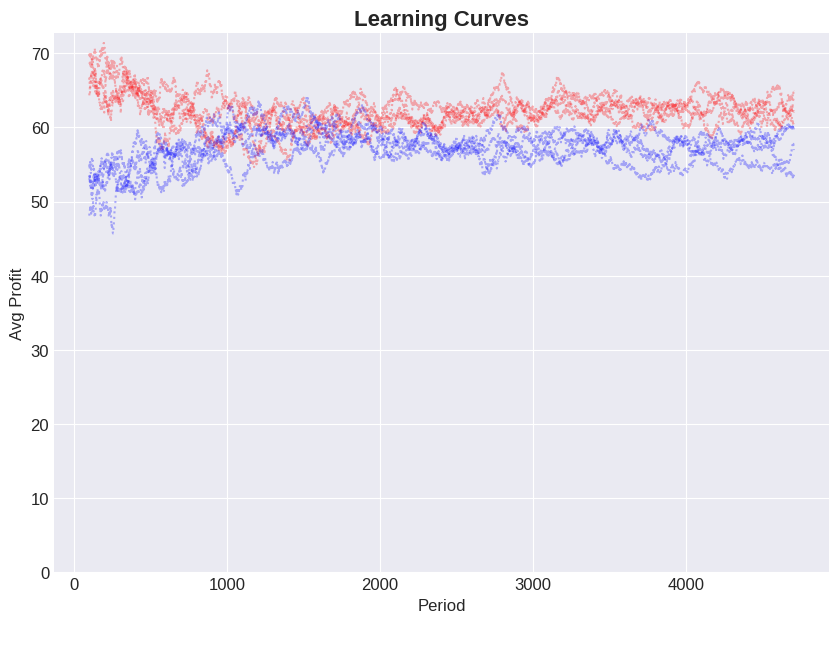

In [25]:
log.findCurrentTraders()
log.graphLearning(rolling_window = 100, trackBuyersIdx=[], trackSellersIdx=[], type = 'rnd')

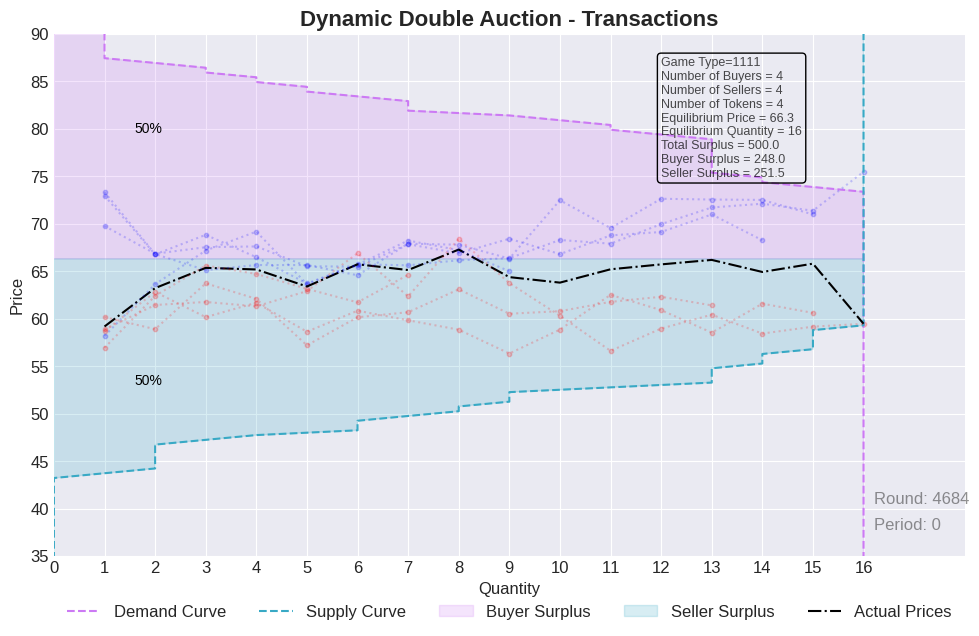

In [28]:
period = 1
log.graphSales(rnd-20, period-1, trackBuyersIdx=[], trackSellersIdx=[])

### Last 100 Rounds

In [9]:
df = log.stepData[log.stepData.rnd>(rnd-100)]
df_rnd = log.roundData[log.roundData.rnd>(rnd-100)]

In [10]:
df.columns

Index(['rnd', 'period', 'step', 'currentBid', 'currentAsk', 'buy', 'sell',
       'price', 'sale', 'currentBidIdx_0', 'currentBidIdx_1',
       'currentBidIdx_2', 'currentBidIdx_3', 'currentAskIdx_0',
       'currentAskIdx_1', 'currentAskIdx_2', 'currentAskIdx_3', 'bids_0',
       'bids_1', 'bids_2', 'bids_3', 'asks_0', 'asks_1', 'asks_2', 'asks_3',
       'bprofit', 'sprofit', 'currentBidIdx', 'currentAskIdx', 'tprofit',
       'bids', 'asks'],
      dtype='object')

### Efficiency

In [11]:
x = np.array(df.groupby('rnd').tprofit.sum().values)
y = np.array(df_rnd.totalSurplus)
df_rnd['EFF'] = x/y
df_rnd['EFF'].describe()

count    100.000000
mean       0.990667
std        0.061004
min        0.393692
25%        0.999338
50%        1.000062
75%        1.000540
max        1.001225
Name: EFF, dtype: float64

In [20]:
x = np.array(df.groupby('rnd').bprofit.sum().values)
y = np.array(df_rnd.buyerSurplus)
df_rnd['EFF'] = x/y
df_rnd['EFF'].describe()

count    100.000000
mean       1.065478
std        0.152068
min        0.406311
25%        0.984041
50%        1.059173
75%        1.145707
max        1.627966
Name: EFF, dtype: float64

In [21]:
x = np.array(df.groupby('rnd').sprofit.sum().values)
y = np.array(df_rnd.sellerSurplus)
df_rnd['EFF'] = x/y
df_rnd['EFF'].describe()

count    100.000000
mean       0.944766
std        0.130863
min        0.380550
25%        0.869092
50%        0.933680
75%        1.009303
max        1.526139
Name: EFF, dtype: float64

### Dispersion

In [14]:
x = df[['rnd', 'price']]
x.groupby('rnd').std().mean(), x.groupby('rnd').std().std()

(price    2.157905
 dtype: float64,
 price    0.652917
 dtype: float64)

In [15]:
x = df[['rnd', 'price']]
y = df_rnd[['rnd', 'peq']]
z = pd.merge(x, y, on='rnd')
z['dev'] = z['price'].sub(z['peq']).abs()
z.groupby('rnd').mean().mean()

price    64.405645
peq      65.322000
dev       2.285758
dtype: float64

In [16]:
z.groupby('rnd').mean().std()

price    0.600363
peq      2.099523
dev      0.999650
dtype: float64

In [17]:
autocorr_by_round = df.groupby('rnd')['price'].apply(lambda x: x.autocorr(lag=1))
x = pd.merge(df, autocorr_by_round.reset_index(name='autocorr'), on='rnd')
x.autocorr.mean(), x.autocorr.std()

(0.019698061684167854, 0.3252876874209751)

### Switching

In [18]:
buyer_switch_mask = df['currentBidIdx'].ne(df['currentBidIdx'].shift())
seller_switch_mask = df['currentAskIdx'].ne(df['currentAskIdx'].shift())
buyer_switch_count = df.groupby('rnd')['period'].apply(lambda x: (buyer_switch_mask & (x == x.shift())).sum())
seller_switch_count = df.groupby('rnd')['period'].apply(lambda x: (seller_switch_mask & (x == x.shift())).sum())

print("Number of buyer switches within each round:")
print(np.mean(buyer_switch_count)/16)

print("\nNumber of seller switches within each round:")
print(np.mean(seller_switch_count)/16)

Number of buyer switches within each round:
0.640625

Number of seller switches within each round:
0.604375
